<a href="https://colab.research.google.com/github/khaqanashraf/video-scraping/blob/master/VideoScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import urllib
from bs4 import BeautifulSoup
# from pytube import YouTube
import cv2
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# the function scrap frames from an image

def get_frames_from_video(video_path , delay):
    
    """
        video_path is the path to the video with video formate
        e.g '/content/gdrive/My Drive/videos/video.mp4'


        delay is the parameter to fetch a frame from video after a certain delay
        like you want to fetch each frame after 5 seconds


        it will return each frame fetched from the video given by video_path after 
        each delay given by 'delay' parameter in numpy
    
    """
        

    
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    frames = list()
    fps = int(vidcap.get(cv2.CAP_PROP_FPS))
    i = 0
    while success: 
      
        frames.append(image)
        success,image = vidcap.read()

        print(f'Read a new frame{i}: ', success)
        count += delay*fps
        i+=1
        vidcap.set(1, count)
    return  np.array(frames)


def scrap_faces_from_image(image, cascade_path):

    """
          image: is the numpy multidimensional array having pixel values of images at location

          cascade_path: it is a complete path to an xml document. 
          this xml document contains real values of pretrained model.
          for scraping of faces we can use cascade_frontalface_default or any other varient.
          the related pre trained values can be found at 'https://github.com/opencv/opencv/tree/master/data/haarcascades'

          it will return boxes e.i coordinates of faces detected in the image
          there could be more than one face
          each face is coordinated with x,y,w,h (x and y are the left top corner of the box whereas 'w' is the width of the box and 'h' is the height of the box)
    
    """

    face_cascade = cv2.CascadeClassifier(cascade_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

def crop_faces_from_image(faces, img):

    """
          faces: is the numpy multidimensional array containing coordinates of each faces the image contained
          each face box can be expressed as the following tuple (x,y,w,h)

          img: is the image containing some faces


          return: the function return a multidiemnsional numpy array containg cropped faces according to given coordinates in 'faces'
    """

    face_images = list()
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face_image = img[y:y+h, x:x+w]
        face_images.append(face_image)

    return np.array(face_images)



def fetch_files_from_directory(directory):
    """
    
        directory: the source directory which contains files
        the function fetch all files within the directory and return a list of file names
    
    """
  
    return [f for f in listdir(directory) if isfile(join(directory, f))]



def scrap_faces_from_videos(src_dir, des_dir, cascade_path, gray_scale = True, delay=5):

    """
          src_dir: it is a source directory path where video files are placed. this function fetch all video files from that source directory.
          

          des_dir: the destination directory where all scaped faces would be placed


          cascade_path: it is a complete path to an xml document. 
          this xml document contains real values of pretrained model.
          for scraping of faces we can use cascade_frontalface_default or any other varient.
          the related pre trained values can be found at 'https://github.com/opencv/opencv/tree/master/data/haarcascades'

          gray_scale: a boolean variable which determins either you want to save faces in a gray scale or note. Default is True.


          delay: is the parameter to fetch a frame from video after a certain delay
          like you want to fetch each frame after 5 seconds

    
    """

    files = fetch_files_from_directory(src_dir)
    i = 0
    for f in files:
        video_path = f'{src_dir}/{f}'
        frames = get_frames_from_video(video_path, delay)
        croped_faces = list()
        for frame in frames:
            faces = scrap_faces_from_image(frame, cascade_path)
            croped_faces.extend(crop_faces_from_image(faces, frame))

        croped_faces = np.array(croped_faces)

        for face in croped_faces:
            if gray_scale:
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(f'{des_dir}/face{i}.jpg', face)
        i += 1



def anotate_frame(frame, faces, label):

    """
        frame: a multidimensional numpy array of pixel values representing a frame or an image
        faces: coordinates of the faces in that image that has to be annotated
        label: the text that should appear on boxes 


        return: the anotated image with a box to face and a label on it
        
    
    """

    for (x,y,w,h) in faces:
        img = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(img, label, (x,y-50), cv2.FONT_HERSHEY_SIMPLEX, 4,(255, 0, 0)   , 2)

    return img



In [4]:
# directory path where I've placed some mp4 video files for scraping
src_dir = '/content/gdrive/My Drive/video_scraping/dramas'
# directory path for which I want to save scrapped faces from video files
des_dir = '/content/gdrive/My Drive/video_scraping/drama_faces'
# cascade xml file of pre trained model to extract faces
cascade_path = '/content/gdrive/My Drive/video_scraping/haarcascade_frontalface_default.xml'

In [ ]:
scrap_faces_from_videos(src_dir, des_dir, cascade_path, delay=2)

Streaming output truncated to the last 5000 lines.
Read a new frame372:  True
Read a new frame373:  True
Read a new frame374:  True
Read a new frame375:  True
Read a new frame376:  True
Read a new frame377:  True
Read a new frame378:  True
Read a new frame379:  True
Read a new frame380:  True
Read a new frame381:  True
Read a new frame382:  True
Read a new frame383:  True
Read a new frame384:  True
Read a new frame385:  True
Read a new frame386:  True
Read a new frame387:  True
Read a new frame388:  True
Read a new frame389:  True
Read a new frame390:  True
Read a new frame391:  True
Read a new frame392:  True
Read a new frame393:  True
Read a new frame394:  True
Read a new frame395:  True
Read a new frame396:  True
Read a new frame397:  True
Read a new frame398:  True
Read a new frame399:  True
Read a new frame400:  True
Read a new frame401:  True
Read a new frame402:  True
Read a new frame403:  True
Read a new frame404:  True
Read a new frame405:  True
Read a new frame406:  True
Read

In [18]:
img_path = '/content/gdrive/My Drive/video_scraping/emran.jpg'

In [19]:
img = cv2.imread(img_path)
img.shape

(863, 1200, 3)

In [20]:
faces = scrap_faces_from_image(img, cascade_path)
faces

array([[392, 178, 372, 372]], dtype=int32)

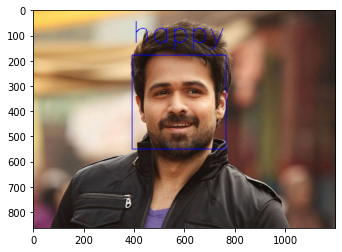

In [22]:
plt.imshow(cv2.cvtColor(anotate_frame(img, faces, 'happy'), cv2.COLOR_BGR2RGB))